In [16]:

from tsp.core.tsp import TSP
from tsp.core.solvers import pyramid_solve
from tsp.experiment.batch_solver import solve_batch
from tsp.experiment.batch import save_problem_batch
import numpy.random as random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import json

cities = TSP.generate_random(50, w=500, h=500)
save_problem_batch([cities], 'pyramid_test/problems')

def pyramid_solve_2_4(problem):
    return pyramid_solve(problem, k=3, s=2)
solve_batch('pyramid_test/problems', pyramid_solve_2_4, 'pyramid_test/pyr_solutions')

def load_tsp_coords(fp):
    with open(fp,'r') as f:
        return np.array(json.load(f)["cities"])

coords = load_tsp_coords("pyramid_test/problems/001.tsp")
num_cities = coords.shape[0]
print("Coords shape:", coords.shape)

tsp_problem = TSP.from_cities(coords, w=500, h=500)

def tour_length(tour: list[int]) -> float:
    idxs   = tour + [tour[0]]
    pts    = coords[idxs]
    deltas = pts[1:] - pts[:-1]
    return np.hypot(deltas[:,0], deltas[:,1]).sum()

history = []  
def recorded_cheapest_insertion(problem: TSP) -> list[int]:
    tour = [0, 1]    
    while len(tour) < num_cities:
        cands = []
        remaining = [i for i in range(num_cities) if i not in tour]
        for city in remaining:
            for pos in range(len(tour)+1):
                cand   = tour[:pos] + [city] + tour[pos:]
                length = tour_length(cand)
                cands.append((cand, length))
        cands.sort(key=lambda x: x[1])
        candidate_tours = [c for c,_ in cands]
        best_idx = 0
        history.append((tour.copy(), candidate_tours, best_idx))
        tour = candidate_tours[best_idx]
    return tour

history.clear()
final_tour = recorded_cheapest_insertion(tsp_problem)
print("Recorded steps:", len(history))



Coords shape: (50, 2)
Recorded steps: 48


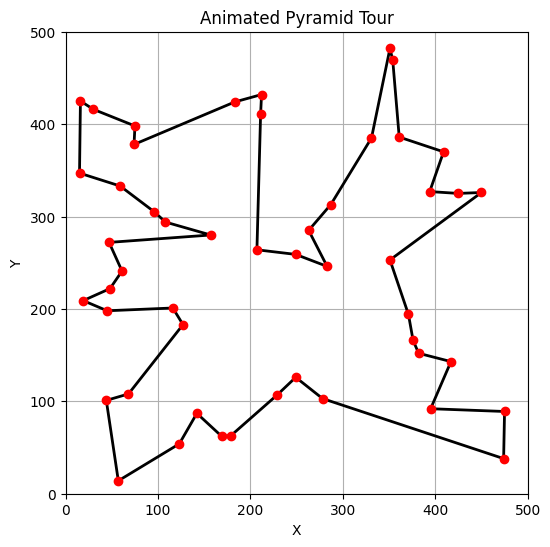

In [ ]:
'''%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
plt.rcParams['animation.html'] = 'jshtml'

tour_coords = coords[tour + [tour[0]]]

fig, ax = plt.subplots(figsize=(6, 6))
line, = ax.plot([], [], 'k-', lw=2)
points = ax.plot(coords[:, 0], coords[:, 1], 'ro')[0]

ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.set_title("Animated Pyramid Tour")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
ax.set_aspect('equal')

def init():
    line.set_data([], [])
    return line, points

def update(frame):
    x = tour_coords[:frame+1, 0]
    y = tour_coords[:frame+1, 1]
    line.set_data(x, y)
    return line, points
from IPython.display import HTML

ani = animation.FuncAnimation(
    fig, update, frames=len(tour_coords), init_func=init,
    interval=120, blit=True, repeat=False
)
HTML(ani.to_jshtml())
plt.show()
ani.save("pyramid_tour1.gif", writer="pillow", fps=10)'''


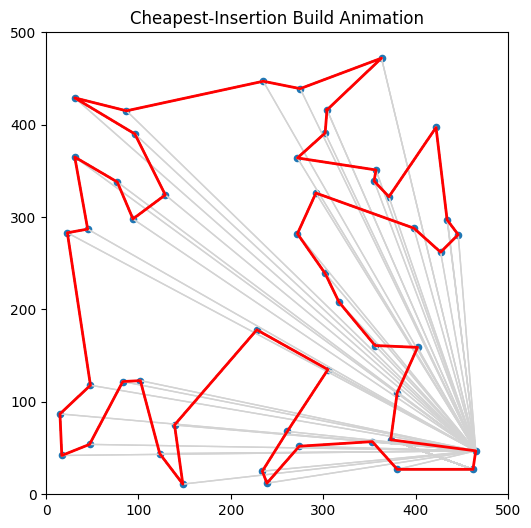

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

all_cand_xy = []
chosen_xy   = []
for partial, cands, best_idx in history:
    cand_loops = [ coords[c + [c[0]]] for c in cands ]
    all_cand_xy.append(cand_loops)
    chosen   = cands[best_idx] + [cands[best_idx][0]]
    chosen_xy.append(coords[chosen])

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(coords[:,0], coords[:,1], s=20)
ax.set(xlim=(0,500), ylim=(0,500), aspect="equal",
       title="Cheapest‑Insertion Build Animation")

max_cands = max(len(c) for c in all_cand_xy)
gray_lines = [ ax.plot([], [], lw=1, color="lightgray")[0]
               for _ in range(max_cands) ]
red_line   = ax.plot([], [], lw=2, color="red")[0]

def init():
    for ln in gray_lines: ln.set_data([], [])
    red_line.set_data([], [])
    return gray_lines + [red_line]

def update(i):
    for ln, xy in zip(gray_lines, all_cand_xy[i]):
        ln.set_data(xy[:,0], xy[:,1])
    for ln in gray_lines[len(all_cand_xy[i]):]:
        ln.set_data([], [])
    xy = chosen_xy[i]
    red_line.set_data(xy[:,0], xy[:,1])
    return gray_lines + [red_line]

ani = animation.FuncAnimation(
    fig, update, frames=len(history),
    init_func=init, interval=300, blit=True, repeat=False
)

HTML(ani.to_jshtml())

ani.save("cheapest_insertion.gif", writer="pillow", fps=4)
